In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from datetime import datetime, timedelta, date
import time
import os
import sys
import json
sys.path.append(os.path.abspath(os.path.join('..')))

/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [32]:
%load_ext autoreload
%autoreload 2

from helpers.db_query import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Weekly video count

In [3]:
video_dates = pd.read_csv('../data/lin_alg_moodle/videos.csv', index_col=0)
video_dates['Due_date'] = pd.to_datetime(video_dates.Due_date)

In [4]:
def select_by_year(video_dates, year):
    return video_dates.loc[video_dates.Due_date.dt.year == year]

video_dates_2017, video_dates_2018, video_dates_2019 = [select_by_year(video_dates, year) for year in [2017,2018, 2019]]

In [5]:
def weekly_count(video_dates):
    return video_dates.groupby(pd.Grouper(key='Due_date',freq='W-THU')).size().values

count_2017, count_2018, count_2019 = [weekly_count(dates) for dates in [video_dates_2017, video_dates_2018,video_dates_2019]]
print("2017", count_2017)
print("2018", count_2018)
print("2019", count_2019)

2017 [ 6  9  6 12  7]
2018 [ 7 10 10  6 13  7  8  7  9  6]
2019 [ 5  4  8  7  7 10 11 13  7  8  6  9  6]


# Features
## Video views

In [6]:
events = getVideoEvents(mode='all')

In [7]:
events.sample()

,DataPackageID,AccountUserID,VideoID,TimeStamp,EventType,SeekType,OldTime,CurrentTime,NewTime,OldSpeed,NewSpeed,Date,Year
404641,EPFL-AlgebreLineaire-2019,95491,2578fb61055d4ddbba9cc09ab8d5f260,1570096583,Video.Pause,None,NaN,142.275,NaN,NaN,NaN,2019-10-03 09:56:23,2019


In [8]:
user_events = events.loc[events.AccountUserID == '47670']

### Total views

In [9]:
def total_views(df):
    """ 
    Counts the total of videos views (rewatch included)
    Assumption: consider that a video is watched at most once per day
    """
    copy = df.copy()
    copy['Day'] = df.Date.dt.date
    #From the assumption the video view is a unique pair (video id, day)
    return len(copy.drop_duplicates(subset=['VideoID','Day'])) 
print("Total number of videos watched",total_views(user_events))

Total number of videos watched 106


### Weekly proportion (watched/replayed/interrupted)

In [77]:
def week_video_total(year):
    """
    Returns a Series with week numbers as index and the number of videos to watch per week
    """
    with open('../config/linear_algebra.json') as f:
        config = json.load(f)
    year = str(year)
    weekly_count = config[year]["WeeklyVideoCount"]
    flipped_weeks = len(config[year]["FlippedWeeks"])
    start_week = int(datetime.strptime(config[year]["StartFlipped"], '%Y-%m-%d').strftime("%V")) #Get the 1st week number
    weeks = list(range(start_week, start_week + flipped_weeks))
    return pd.DataFrame(index=weeks, data=weekly_count, columns=["Total"])

def get_dated_videos():
    PATH = '../data/lin_alg_moodle/video_with_durations.csv'
    dated_videos = pd.read_csv(PATH, index_col=0)
    dated_videos['Due_date'] = pd.to_datetime(dated_videos['Due_date']) #Convert String to datetime
    dated_videos['Year'] = dated_videos.Due_date.dt.year #Add year column
    return dated_videos

def videos_watched_on_right_week(user_events):
    dated_videos = get_dated_videos()
    first_views = user_events.merge(dated_videos, on=['VideoID', 'Year'])
    first_views['From_date'] = first_views.Due_date - timedelta(weeks=1)
    return first_views[(first_views.Date >= first_views.From_date) & (first_views.Date <= first_views.Due_date)]

def weekly_prop(user_events):
    """Compute the ratio of video events in the dataframe over the videos assigned weekly the user_events
    may only contained only the first viewings, only rewatched videos or only interrupted videos."""
    first_views = videos_watched_on_right_week(user_events)
    #Freq Weekly starting on Thursday since the last due date is on Thursday
    weekly_count = first_views.groupby(pd.Grouper(key="Date", freq="W-THU")).size().to_frame(name="Count")
    #Convert dates to week number
    weekly_count.index = [int(week) for week in weekly_count.index.strftime("%V")]
    #Number of assigned videos per week
    weekly_total = week_video_total(user_events.Year.iloc[0])
    #Merge and compute the ratio of watched
    weekly_prop = weekly_total.merge(weekly_count, left_index=True, right_index=True)
    return np.clip((weekly_prop.Count / weekly_prop.Total).values,0,1)

In [11]:
# Average and SD of the proportion of videos watched per week
def weekly_prop_watched(user_events):
    """Compute the proportion of videos watched (nb of videos watched / nb of videos assigned)"""
    first_views = user_events.drop_duplicates(subset=["VideoID"]) #Only keep the first views per video
    return weekly_prop(first_views)

def avg_weekly_prop_watched(df): 
    return weekly_prop_watched(df).mean()

def std_weekly_prop_watched(df):
    return weekly_prop_watched(df).std()

print("Videos watched")
print("Average",avg_weekly_prop_watched(user_events))
print("SG",std_weekly_prop_watched(user_events))

Videos watched
Average 0.360827664399093
SG 0.2744136024538823


In [12]:
# Average and SD of the proportion of videos replayed per week
def weekly_prop_replayed(user_events):
    """Compute the proportion of videos replayed (nb of videos replayed / nb of videos assigned)"""
    # We assume that a student watches a video at most once per day (cannot have multiple replays in one day)
    replayed_events = user_events.copy()
    replayed_events['Day'] = replayed_events.Date.dt.date #Create column with the date but not the time
    replayed_events.drop_duplicates(subset=['VideoID', 'Day'], inplace=True) #Only keep on event per video per day
    replayed_events = replayed_events[replayed_events.duplicated(subset=['VideoID'])] # Keep the replayed videos
    return weekly_prop(replayed_events)

def avg_weekly_prop_replayed(df): 
    return weekly_prop_replayed(df).mean()

def std_weekly_prop_replayed(df):
    return weekly_prop_replayed(df).std()

print("Videos replayed")
print("Average",avg_weekly_prop_replayed(user_events))
print("SG",std_weekly_prop_replayed(user_events))

Videos replayed
Average 0.10912698412698411
SG 0.05764221843783314


In [78]:
def weekly_prop_interrupted(user_events):
    STOP_EVENTS = ['Video.Pause', 'Video.Stop', 'Video.Load']
    df = user_events.copy() #Sort in descreasing order
    video_durations = get_dated_videos().drop_duplicates(subset=['VideoID'])[['VideoID', 'Duration']]
    df = df.merge(video_durations)
    df.sort_values(by="TimeStamp", inplace=True)
    df['Diff'] = abs(df.TimeStamp.diff(-1))
    df['NextVideoID'] = df.VideoID.shift(-1)
    
    df = df[(df.Duration - df.CurrentTime > 60)] #Remove events in the last minute
    # Interruption when
    #   * a break is too long
    #   * a break (not in the last minute) is followed by an event in another video (the user left the video)
    #   * an event occurs in another video before the end of the current video
    break_too_long = (df.EventType.isin(STOP_EVENTS)) & (df.Diff > 3600)
    break_then_other_video = (df.EventType.isin(STOP_EVENTS)) &  (df.VideoID != df.NextVideoID)
    event_other_video = (df.VideoID != df.NextVideoID) & ((df.Duration - df.CurrentTime) > (df.Diff))
    interrup_conditions = break_too_long | break_then_other_video | event_other_video
    df = df[interrup_conditions]
    return weekly_prop(df)

interrup = weekly_prop_interrupted(user_events)    
interrup

array([0.33333333, 0.        , 0.        , 0.        , 0.        ,
       0.33333333])

In [69]:
interrup

,DataPackageID,AccountUserID,VideoID,TimeStamp,EventType,SeekType,OldTime,CurrentTime,NewTime,OldSpeed,NewSpeed,Date,Year,Chapter,Subchapter,Source,Due_date,Duration,Diff,NextVideoID
425,EPFL-AlgebreLineaire-2018,47670,260ca300105d450c8b7b60076cae50ee,1540818669,Video.Pause,None,NaN,0.654004,NaN,NaN,NaN,2018-10-29 13:11:09,2018,3,3.60,https://www.youtube.com/watch?v=so5M6k21vq8,2018-10-16,377.0,10934.0,260ca300105d450c8b7b60076cae50ee
626,EPFL-AlgebreLineaire-2018,47670,a09c2b7d3b6a42b0a20fd8d0ec2c2ab8,1542312576,Video.Pause,None,NaN,432.174000,NaN,NaN,NaN,2018-11-15 20:09:36,2018,4,4.20,https://www.youtube.com/watch?v=utLWjCCWjv8,2018-10-23,1037.0,240665.0,a8f03261648f427590022f6a46290d28
1195,EPFL-AlgebreLineaire-2018,47670,251c616b45df417f97072346ffeeecb8,1544452662,Video.Pause,None,NaN,519.688000,NaN,NaN,NaN,2018-12-10 14:37:42,2018,9,9.50,https://www.youtube.com/watch?v=1_TRBbZgpRA,2018-12-11,769.0,7923.0,b65d9dcb1a4241fe80f289f7ee37da32
1033,EPFL-AlgebreLineaire-2018,47670,97b12bced6d649a2bca7465b246a1b0f,1544466483,Video.Pause,None,NaN,568.060000,NaN,NaN,NaN,2018-12-10 18:28:03,2018,9,9.70,https://www.youtube.com/watch?v=h8nu5K9Dl0Y,2018-12-11,1306.0,53901.0,97b12bced6d649a2bca7465b246a1b0f
295,EPFL-AlgebreLineaire-2018,47670,f968886ba37f48e983945ded95f07c27,1544523624,Video.Pause,None,NaN,398.759000,NaN,NaN,NaN,2018-12-11 10:20:24,2018,9,9.80,https://www.youtube.com/watch?v=3VNdwb0DT7o,2018-12-13,988.0,84178.0,69c0a7659b0e4e6cbbf15630ab84c771
1128,EPFL-AlgebreLineaire-2018,47670,5a9926d290ee41b79db5a8d233b2f561,1545060662,Video.Pause,None,NaN,873.218000,NaN,NaN,NaN,2018-12-17 15:31:02,2018,9,9.12,https://www.youtube.com/watch?v=CxkCZ2Lcq40,2018-12-13,1246.0,3983.0,ad4b668b3098404da342c8931fe1b2ea


#### Interruption exploration

There is no interruption event. In fact there exists an event called `Video.Stop` but it consists of the union of event types causing an interruption of the video, for instance `Video.Pause` or `Video.Load`. However I noticed that some events occurred at the same time as the end of the video: **is there a "closing event" that always occur at the end of the video?**

In order to test that, the `interruption` function returns the video events occurring in the `time_threshold` last seconds. By computing the proportion of videos where an event occurred in the last seconds and the total number of unique videos watched, we can have a approximative idea of how often an "interruption event" occurs.

In [13]:
def interruption(df, time_threshold=60):
    """Returns events occurring in the last time_threshold seconds (max one event per video) """
    user_event = df.copy()
    user_event['Day'] = user_event.Date.dt.date #Create column with the date but not the time
    dated_videos = get_dated_videos()
    user_event = user_event.merge(dated_videos, on=['VideoID', 'Year'])
    return user_event[abs(user_event.CurrentTime - user_event.Duration) <= time_threshold]\
                                                                    .drop_duplicates(subset=['VideoID'])

print("Number of videos containing an closing event:",len(interruption(user_events)))
print("Total number of distinct videos watched:", len(user_events.drop_duplicates(subset=['VideoID'])))

Number of videos containing an closing event: 70
Total number of distinct videos watched: 85


In [14]:
user_events

,DataPackageID,AccountUserID,VideoID,TimeStamp,EventType,SeekType,OldTime,CurrentTime,NewTime,OldSpeed,NewSpeed,Date,Year
780862,EPFL-AlgebreLineaire-2018,47670,eaee610676f34fb9b729f3c5ba62499b,1541949476,Video.Seek,onSlideSeek,3.09653,NaN,544.0,NaN,NaN,2018-11-11 15:17:56,2018
780863,EPFL-AlgebreLineaire-2018,47670,5bc0ff2e9d6f4418927029a091383450,1545057343,Video.Play,None,NaN,599.2590,NaN,NaN,NaN,2018-12-17 14:35:43,2018
780864,EPFL-AlgebreLineaire-2018,47670,f63f35d6e527434cac3c8c8872f88270,1543843911,Video.Play,None,NaN,1148.8400,NaN,NaN,NaN,2018-12-03 13:31:51,2018
780865,EPFL-AlgebreLineaire-2018,47670,5513f6dfd7314224853327ea7b4e2dfc,1542028768,Video.Play,None,NaN,624.0000,NaN,NaN,NaN,2018-11-12 13:19:28,2018
780866,EPFL-AlgebreLineaire-2018,47670,4a3f41d9f86f4e7da9ebdc6e3a0173f7,1542287493,Video.Play,None,NaN,78.9593,NaN,NaN,NaN,2018-11-15 13:11:33,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...
783596,EPFL-AlgebreLineaire-2018,47670,6f7c4414324047a4b9d12a1d87d5875e,1542464281,Video.Seek,onSlideSeek,255.95500,NaN,80.0,NaN,NaN,2018-11-17 14:18:01,2018
783597,EPFL-AlgebreLineaire-2018,47670,8cf6c396f2114e0fa21a6309cf6626e1,1543335525,Video.Play,None,NaN,519.2020,NaN,NaN,NaN,2018-11-27 16:18:45,2018
783598,EPFL-AlgebreLineaire-2018,47670,ad4b668b3098404da342c8931fe1b2ea,1545065335,Video.Play,None,NaN,361.1310,NaN,NaN,NaN,2018-12-17 16:48:55,2018
783599,EPFL-AlgebreLineaire-2018,47670,251c616b45df417f97072346ffeeecb8,1544445677,Video.Transcript.Hide,None,NaN,NaN,NaN,NaN,NaN,2018-12-10 12:41:17,2018


In [15]:
from tqdm import tqdm

def compute_closing_prop():
    """Compute the proportion of videos containing an closing event for each user"""
    till_end_prop = []
    for userId in tqdm(events.AccountUserID.unique()):
        user_events = events.loc[events.AccountUserID == userId]
        total = len(user_events.drop_duplicates(subset=['VideoID']))
        if total != 0:
            till_end_prop.append(len(interruption(user_events)) / total)
    return np.array(till_end_prop)
if False:
    till_end_prop = compute_closing_prop()
    print("Average proportion of videos with closing event:",till_end_prop.mean())
    print("SD of the proportion of videos with closing event:",till_end_prop.std())

We can see that in average 60% ($\pm$ 25%) of the videos end with an event occurring in the last minute.

## Actions

In [16]:
ACTIONS = ['Video.Play', 'Video.Pause', 'Video.SeekBackward', 
           'Video.SeekForward', 'Video.SpeedChange', 'Video.Stop']

### Total number of actions

In [17]:
def total_actions(user_events):
    """Counts the total number of actions performed across every videos"""
    return len(user_events)

print("Total number of actions:", total_actions(user_events))

Total number of actions: 2739


### Frequency of all actions

In [18]:
def frequency_all_actions(user_events):
    """Compute the frequency of actions performed per hour spent watching videos"""
    user_events = user_events.copy()
    user_events.loc[:,'Day'] = user_events.loc[:,'Date'].dt.date #Create column with the date but not the time
    user_events.drop_duplicates(subset=['VideoID', 'Day'], inplace=True) #Only keep on event per video per day
    durations = get_dated_videos()
    user_events = user_events.merge(durations, on = ["VideoID", "Year"])
    watching_time = user_events.Duration.sum() / 3600 # hours
    return total_actions(user_events) / watching_time if watching_time != 0 else 0

print(frequency_all_actions(user_events),"actions / hour")

4.72589533563976 actions / hour


### Frequency of each action

In [19]:
def count_actions(user_events, action):
    """Count the total number of events with type `action`"""
    if 'Backward' in action:
        user_events = user_events[(user_events.EventType == 'Video.Seek') & 
                                  (user_events.OldTime < user_events.NewTime)]
    elif 'Forward' in action:
        user_events = user_events[(user_events.EventType == 'Video.Seek') & 
                                  (user_events.OldTime > user_events.NewTime)]
    else:
        user_events = user_events[user_events.EventType == action]        
    return len(user_events)

def freq_play(user_events):
    return count_actions(user_events,'Video.Play') / total_actions(user_events)

def freq_pause(user_events):
    return count_actions(user_events,'Video.Pause') / total_actions(user_events)

def freq_seek_backward(user_events):
    return count_actions(user_events,'Video.SeekBackward') / total_actions(user_events)

def freq_seek_forward(user_events):
    return count_actions(user_events,'Video.SeekForward') / total_actions(user_events)

def freq_speed_change(user_events):
    return count_actions(user_events,'Video.SpeedChange') / total_actions(user_events)

def freq_stop(user_events):
    return count_actions(user_events,'Video.Stop') / total_actions(user_events)

total_sum = 0
for action in [freq_play,freq_pause, freq_seek_backward, freq_seek_forward, freq_speed_change, freq_stop]:
    freq = action(user_events)
    total_sum += freq
    print(action.__name__[5:], freq)
    
print("Total proportition:", total_sum)


play 0.40525739320920046
pause 0.38663745892661555
seek_backward 0.013143483023001095
seek_forward 0.03906535231836437
speed_change 0.004016064257028112
stop 0.038335158817086525
Total proportition: 0.8864549105512961


Missing events: `Video.Transcript.Translate.EN`, `Video.Load`

### Pause durations

In [20]:
def pause_duration(user_events, max_duration=500):
    """Compute the time interval between each pause event and the next play event`
    Only pause durataions smaller than `max_duration` are taken into account. 
    Default threshold to 10 min"""
    
    pause_events = user_events[user_events.EventType.isin(["Video.Pause", "Video.Play"])].copy()
    pause_events = pause_events.sort_values(by="TimeStamp")
    pause_events['PrevEvent'] = pause_events['EventType'].shift(1)
    pause_events['Diff'] = pause_events.TimeStamp.diff().dropna()
    pause_events = pause_events[pause_events.PrevEvent == 'Video.Pause']
    nb_pause = len(pause_events)
    pause_events = pause_events[pause_events.Diff < max_duration]
    return pause_events.Diff.values, len(pause_events.Diff.values) / nb_pause

def avg_pause_duration(user_events):
    return pause_duration(user_events)[0].mean()

def std_pause_duration(user_events):
    return pause_duration(user_events)[0].std()

print("Pause durations")
print("Average",avg_pause_duration(user_events))
print("SG",std_pause_duration(user_events))
print("Proportion of pauses included in the threshold:", pause_duration(user_events)[1])

Pause durations
Average 74.6760710553814
SG 107.29078244629652
Proportion of pauses included in the threshold: 0.9045368620037807


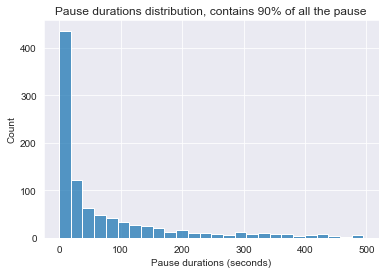

In [21]:
pauses = pause_duration(user_events, 500)
sns.histplot(pauses[0])
plt.xlabel("Pause durations (seconds)")
plt.title("Pause durations distribution, contains {:.0f}% of all the pause".format(pauses[1] * 100));

From the above histgram, 500 seconds (around 8 minutes) seems to be a reasonable threshold as 90% of all the pause durations are below this threshold and that as the duration increase the count tends to 0.

### Seek Length

In [22]:
def seek_length(user_events):
    user_events = user_events[user_events.EventType == 'Video.Seek']
    return abs(user_events.OldTime - user_events.NewTime).values

def avg_seek_length(user_events):
    return seek_length(user_events).mean()

def std_seek_length(user_events):
    return seek_length(user_events).std()

print("Seek length")
print("Average",avg_seek_length(user_events))
print("SG",std_seek_length(user_events))

Seek length
Average 102.10219379166668
SG 181.15720351499434


### Time speeding-up video

In [23]:
def compute_speedchange_current_time(user_events):
    #Compute the CurrentTime of the SpeedChange event as it is not logged in the db
    #For that we find the closest event (in the same video and day) with a non null CurrentTime
    #Then we compute the SpeedChange CurrentTime with the delta time between the 2 events

    #Keep only SpeedChange events and events with non null CurrentTime
    df = user_events[(user_events.EventType == 'Video.SpeedChange') | (~user_events.CurrentTime.isna())]
    #Compute the deltatime between the previous events
    df = df.sort_values(by="TimeStamp", ascending=True)
    df['NextDiff'] = abs(df.TimeStamp.diff())
    df['PrevDiff'] = abs(df.TimeStamp.diff(-1))

    ### Define the closest event information: VideoID, TimeStamp and CurrentTime ###
    df['NextVideoID'] = df.VideoID.shift()
    df['NextTimeStamp'] = df.TimeStamp.shift()
    df['NextCurrentTime'] = df.CurrentTime.shift()
    df['PrevVideoID'] = df.VideoID.shift(-1)
    df['PrevTimeStamp'] = df.TimeStamp.shift(-1)
    df['PrevCurrentTime'] = df.CurrentTime.shift(-1)

    df['ClosestVideoID'] = np.nan
    df['ClosestTimeStamp'] = np.nan
    df['ClosestCurrentTime'] = np.nan
    #If the next event is the closest
    df.loc[df.NextDiff <= df.PrevDiff, 'ClosestVideoID'] = df[df.NextDiff <= df.PrevDiff].NextVideoID
    df.loc[df.NextDiff <= df.PrevDiff, 'ClosestTimeStamp'] = df[df.NextDiff <= df.PrevDiff].NextTimeStamp
    df.loc[df.NextDiff <= df.PrevDiff, 'ClosestCurrentTime'] = df[df.NextDiff <= df.PrevDiff].NextCurrentTime
    #If the previous event is the closest
    df.loc[df.NextDiff > df.PrevDiff, 'ClosestVideoID'] = df[df.NextDiff > df.PrevDiff].PrevVideoID
    df.loc[df.NextDiff > df.PrevDiff, 'ClosestTimeStamp'] = df[df.NextDiff > df.PrevDiff].PrevTimeStamp
    df.loc[df.NextDiff > df.PrevDiff, 'ClosestCurrentTime'] = df[df.NextDiff > df.PrevDiff].PrevCurrentTime

    #Filter the SpeedChange events
    df = df[(df.EventType == 'Video.SpeedChange') & (df.VideoID == df.ClosestVideoID) &
               (~df.ClosestCurrentTime.isna())]
    df.drop(columns=['NextDiff', 'NextVideoID','NextTimeStamp',"NextCurrentTime",'PrevDiff', "PrevVideoID", 
                       "PrevTimeStamp", "PrevCurrentTime", "ClosestVideoID", 'SeekType', 'OldTime',
                       'NewTime', 'AccountUserID', 'Date', 'Year'],inplace=True)
    df['CurrentTime'] = df.ClosestCurrentTime + abs(df.TimeStamp - df.ClosestTimeStamp)

    #Duration are the same through the year, we can simply keep the first VideoID
    video_durations = get_dated_videos().drop_duplicates(subset=['VideoID']) 
    df = df.merge(video_durations, on=['VideoID'])
    df = df[df.CurrentTime < df.Duration]
    
    df.drop(columns=['ClosestTimeStamp', 'ClosestCurrentTime', 'Chapter', 'Subchapter', 'Source', 
                   'Due_date', 'Year'],inplace=True)
    return df

compute_speedchange_current_time(user_events)

,DataPackageID,VideoID,TimeStamp,EventType,CurrentTime,OldSpeed,NewSpeed,Duration
0,EPFL-AlgebreLineaire-2018,84e4c0085f724d5ca97e1724ce636238,1539695978,Video.SpeedChange,3.061238,1.00,1.50,1426.0
1,EPFL-AlgebreLineaire-2018,84e4c0085f724d5ca97e1724ce636238,1539697421,Video.SpeedChange,1008.860000,1.50,1.00,1426.0
2,EPFL-AlgebreLineaire-2018,54ac00d607ef49e68dfa9579b7ad43f0,1540207529,Video.SpeedChange,3.099860,1.00,1.25,1023.0
3,EPFL-AlgebreLineaire-2018,54ac00d607ef49e68dfa9579b7ad43f0,1540207572,Video.SpeedChange,38.734670,1.25,1.50,1023.0
4,EPFL-AlgebreLineaire-2018,c8b2017357a74a889c2db24746fa95e8,1540212375,Video.SpeedChange,682.687000,1.25,1.00,1093.0
5,EPFL-AlgebreLineaire-2018,6009306465a74cce84717e07e4e22bdf,1540466790,Video.SpeedChange,2.090587,1.00,1.25,411.0
6,EPFL-AlgebreLineaire-2018,6009306465a74cce84717e07e4e22bdf,1540466932,Video.SpeedChange,31.675700,1.25,1.00,411.0
7,EPFL-AlgebreLineaire-2018,260ca300105d450c8b7b60076cae50ee,1540832028,Video.SpeedChange,203.753000,1.00,1.25,377.0
8,EPFL-AlgebreLineaire-2018,73f3f756e43047c0b161c9ea29fb08a2,1541431369,Video.SpeedChange,5.194430,1.25,1.00,726.0
9,EPFL-AlgebreLineaire-2018,a09c2b7d3b6a42b0a20fd8d0ec2c2ab8,1541608715,Video.SpeedChange,3.036278,1.00,1.25,1037.0


In [29]:
def compute_time_speeding_up(user_events):
    """Compute the time spent with a high spedd (> 1) for each video"""
    df = user_events.copy()
    sc = compute_speedchange_current_time(user_events)[['TimeStamp', 'EventType', 'CurrentTime']]
    df = df.merge(sc, on=['TimeStamp', 'EventType'], how='left')
    df['CurrentTime'] = np.where(df.CurrentTime_y.isna(), df.CurrentTime_x, df.CurrentTime_y)
    df.drop(columns=['CurrentTime_x', 'CurrentTime_y'], inplace=True)
    df = df.sort_values(by='TimeStamp')

    def label_speed(row):
        global speed
        newSpeed = speed if np.isnan(row) else row
        speed = newSpeed
        return newSpeed

    speed = 1

    df['Speed'] = df.NewSpeed.apply(lambda row: label_speed(row))
    df['NextVideoID'] = df.VideoID.shift(-1)

    video_durations = get_dated_videos().drop_duplicates(subset=['VideoID'])[['VideoID', 'Duration']]
    df = df.merge(video_durations)

    df['SpeedUpTime'] = abs(df.TimeStamp.diff(-1))

    #If the SpeedUpTime is Nan (last elem of DataFrame) or if the next events is in another video
    #then the time speeding up is until the end of the video
    conditions = (df.SpeedUpTime.isna()) | (df.VideoID != df.NextVideoID)
    df['SpeedUpTime'] = np.where(conditions, df.Duration - df.CurrentTime, df.SpeedUpTime)

    #When the speed is switched back to normal or slower then we stop counting
    conditions = (df.Speed <= 1) | (df.EventType.isin(['Video.Stop', 'Video.Pause'])) | \
                (df.SpeedUpTime > 3600)
    df['SpeedUpTime'] = np.where(conditions, 0, df.SpeedUpTime)
    return df.groupby('VideoID').SpeedUpTime.sum().values

def avg_time_speeding_up(user_events):
    return compute_time_speeding_up(user_events).mean()

def std_time_speeding_up(user_events):
    return compute_time_speeding_up(user_events).std()

print("Time speeding up")
print("Average",avg_time_speeding_up(user_events))
print("SG",std_time_speeding_up(user_events))

Time speeding up
Average 793.5551505185185
SG 557.4589334981438


In [38]:
video_info = getVideoEventsInfo()

In [44]:
problem_info = getProblemEventsInfo()

MergeError: No common columns to perform merge on. Merge options: left_on=None, right_on=None, left_index=False, right_index=False

In [ ]:
problem_info